# Student Model -Transformer

## Preparing the Data

In [1]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
%pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 37.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [5]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [6]:
from datasets import load_dataset
import pandas as pd
data = load_dataset("bentrevett/multi30k")
train_data, valid_data, test_data = data['train'], data['validation'], data['test']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
import random
from torchtext.vocab import Vocab, vocab
from collections import Counter
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

Load Data Haokun

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# src, trg = 'de', 'en'
# dataset = 'multi30k'
# file_path = "/content/drive/MyDrive/Master_Project/Data/Multi30k/"
# trg_T = torch.load(file_path + f'Teacher_Translations_{dataset}_{src}_{trg}.pth')
# bleu_tokens_TR = torch.load(file_path + f'bleu_tokens_c10_{dataset}_{src}_{trg}.pth')

Load Data Yijie

In [10]:
src, trg = 'de', 'en'
dataset = 'multi30k'
# trg_T = torch.load(f'Teacher_Translations_{dataset}_{src}_{trg}.pth') # dict
# bleu_tokens_TR = torch.load(f'bleu_tokens_c10_{dataset}_{src}_{trg}.pth') # dict
bleu_SR_train = torch.load(f'bleu_SR_train')
bleu_SR_test = torch.load(f'bleu_SR_test')

### Split with Prob Distribution

In [11]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
def batch_sentence_bleu(hypotheses, references, tokenizer=tokenize_en):
    if type(hypotheses[0]) != list:
        hypotheses = [tokenizer(s) for s in hypotheses]
    if type(references[0]) != list:
        references = [tokenizer(s) for s in references]
    bleu_scores = []
    for i, hypothesis in enumerate(hypotheses):
        # bleu_score = sentence_bleu(references=[references[i]], hypothesis=hypothesis, smoothing_function = SmoothingFunction().method1)
        bleu_score = sentence_bleu(references=[references[i]], hypothesis=hypothesis)
        bleu_scores.append(round(bleu_score * 100, 4))
        # if bleu_score < 1:
          # print(references[i], hypothesis)

    corpus_bleu_score = corpus_bleu(list_of_references=[[ref] for ref in references], hypotheses=hypotheses, smoothing_function = SmoothingFunction().method1)
    return bleu_scores, corpus_bleu_score


In [12]:
# Compare the output of Teacher model with the Reference from original dataset
# bleu_TR, corpus_bleu_TR = batch_sentence_bleu(trg_T['train'], train_data['en'])
# print(f'Corpus bleu score is {corpus_bleu_TR}')
# plot_bleu_distribution(bleu_TR)
# sorted_bleu_TR = sorted(bleu_TR)
sorted_bleu_TR = sorted(bleu_SR_train)
sub_lists = [[x for x in sorted_bleu_TR if x == 0]]
sorted_non_zeros_bleu_TR = [x for x in sorted_bleu_TR if x != 0]
sub_lists.extend(np.array_split(sorted_non_zeros_bleu_TR, 9))
avg_list = []
bounds = []
for i, sublist in enumerate(sub_lists):
    avg = round(np.mean(sublist))
    avg_list.append(avg)
    bounds.append(sublist[-1])
    print(f"Avg value list {i + 1}: {avg}, bound: {sublist[-1]}")
bounds[-1] = 100.0

Avg value list 1: 0, bound: 0.0
Avg value list 2: 25, bound: 31.0071
Avg value list 3: 35, bound: 38.9894
Avg value list 4: 43, bound: 46.9247
Avg value list 5: 51, bound: 54.4518
Avg value list 6: 59, bound: 62.6284
Avg value list 7: 66, bound: 70.2046
Avg value list 8: 76, bound: 80.9107
Avg value list 9: 86, bound: 89.3154
Avg value list 10: 91, bound: 100.0


In [13]:
def map_bleu_scores_to_tokens_avg(bleu_scores):

    BLEU_tokens = []

    for bleu_score in bleu_scores:
        for i, upper_bound in enumerate(bounds):
            if bleu_score <= upper_bound:
                BLEU_tokens.append(f'bleu_{avg_list[i]}')
                break
    assert len(BLEU_tokens) == len(bleu_scores)
    return BLEU_tokens

In [14]:
bleu_SR_train_token = map_bleu_scores_to_tokens_avg(bleu_SR_train)

In [16]:
train_data = train_data.rename_column('en', 'ref')
trg_T_train = [x[0][:300] + " " + x[1] for x in zip(train_data['ref'], bleu_SR_train_token)] # bleu score last
train_data = train_data.add_column(name='en', column=trg_T_train)
train_data, train_data[0]

(Dataset({
     features: ['ref', 'de', 'en'],
     num_rows: 29000
 }),
 {'ref': 'Two young, White males are outside near many bushes.',
  'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
  'en': 'Two young, White males are outside near many bushes. bleu_51'})

features: ['ref', 'de', 'en'] -- [original data en, original data de, Trg_T with bleu token]

In [17]:
import os
if os.path.exists('ger_vocab.pth') and os.path.exists('eng_vocab.pth'):
    ger_vocab = torch.load('ger_vocab.pth')
    eng_vocab = torch.load('eng_vocab.pth')
else:
    ger_counter = Counter()
    eng_counter = Counter()
    for data in tqdm(train_data):
        ger_counter.update(tokenize_de(data['de'].lower()))
        eng_counter.update(tokenize_en(data['en'].lower()))

    ger_vocab = vocab(ger_counter,
                    min_freq=2,
                    specials=["<unk>", "<pad>", "<sos>", "<eos>"])
    eng_vocab = vocab(eng_counter,
                    min_freq=2,
                    specials=["<unk>", "<pad>", "<sos>", "<eos>"])

    # if word does not exist in the vocab, assign default index to that word
    ger_vocab.set_default_index(ger_vocab["<unk>"])
    eng_vocab.set_default_index(eng_vocab["<unk>"])
    print(f"Size of German Vocab : {len(ger_vocab)}\nSize of English Vocab : {len(eng_vocab)}")
    torch.save(ger_vocab, 'ger_vocab.pth')
    torch.save(eng_vocab, 'eng_vocab.pth')

100%|██████████| 29000/29000 [00:10<00:00, 2642.97it/s]


Size of German Vocab : 7853
Size of English Vocab : 5903


In [18]:
text_transform_eng = lambda x: [eng_vocab['<sos>']] + [eng_vocab[token.lower()] for token in tokenize_en(x)] + [eng_vocab['<eos>']]
text_transform_ger = lambda x: [ger_vocab['<sos>']] + [ger_vocab[token.lower()] for token in tokenize_de(x)] + [ger_vocab['<eos>']]

def collate_batch(batch):
    src_list, tgt_list = [], []
    for data in batch:
        src_list.append(torch.tensor(text_transform_ger(data['de'])))
        tgt_list.append(torch.tensor(text_transform_eng(data['en'])))

    src_list = pad_sequence(src_list, batch_first=True, padding_value=ger_vocab['<pad>'])
    tgt_list = pad_sequence(tgt_list, batch_first=True, padding_value=eng_vocab['<pad>'])

    inp = {
        "src": src_list,
        "trg": tgt_list
    }

    return inp


In [19]:
batch_size = 128

train_dataloader = DataLoader(train_data,
                              collate_fn=collate_batch,
                              shuffle=True,
                              batch_size=batch_size,
                              pin_memory=True)

test_dataloader = DataLoader(test_data,
                              collate_fn=collate_batch,
                              shuffle=False,
                              batch_size=batch_size,
                              pin_memory=True)

valid_dataloader = DataLoader(valid_data,
                              collate_fn=collate_batch,
                              shuffle=False,
                              batch_size=batch_size,
                              pin_memory=True)


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Building the Model

### Encoder

In [21]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        #src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)

        #src = [batch size, src len, hid dim]

        return src

### Encoder Layer

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        #positionwise feedforward
        _src = self.positionwise_feedforward(src)

        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        return src

### Mutli Head Attention Layer

In [23]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        #attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        #x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        #x = [batch size, query len, n heads, head dim]

        x = x.reshape(batch_size, -1, self.hid_dim)

        #x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        #x = [batch size, query len, hid dim]

        return x, attention

### Position-wise Feedforward Layer

In [24]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        #x = [batch size, seq len, pf dim]

        x = self.fc_2(x)

        #x = [batch size, seq len, hid dim]

        return x

### Decoder

In [25]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        #trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        #output = [batch size, trg len, output dim]

        return output, attention

### Decoder Layer

In [26]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        return trg, attention

### Seq2Seq

In [27]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)

        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## Training the Seq2Seq Model

In [28]:
INPUT_DIM = len(ger_vocab)
OUTPUT_DIM = len(eng_vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

SRC_PAD_IDX = ger_vocab['<pad>']
TRG_PAD_IDX = eng_vocab['<pad>']

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)
print()

The model has 9,043,471 trainable parameters



In [30]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

# weights = torch.ones(OUTPUT_DIM).to(device)
# weights[-2] = 3.0
# weights[0] = 3.0

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX, ) # weight=weights

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [31]:
def train(model, iterator, optimizer, criterion, clip, self_=False):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):
        # if i % 10 == 0:
        #     print(i, '/', len(iterator))

        src = batch['src'].to(device)
        trg = batch['trg'].to(device)

        optimizer.zero_grad()

        output, _ = model(src, trg[:, :-1])

        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.contiguous().reshape(-1, output_dim)
        trg = trg[:,1:].contiguous().reshape(-1)
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [32]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):
            # if i % 10 == 0:
            #     print(i, '/', len(iterator))

            src = batch['src'].to(device)
            trg = batch['trg'].to(device)

            output, _ = model(src, trg[:, :-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().reshape(-1, output_dim)
            trg = trg[:,1:].contiguous().reshape(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')
patience = 0

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)



    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'student-model-bleu.pt')
        patience = 0
    else:
        patience += 1
        if patience >= 5:
            break

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Epoch: 01 | Time: 0m 19s
	Train Loss: 4.211 | Train PPL:  67.410
	 Val. Loss: 3.656 |  Val. PPL:  38.703
Epoch: 02 | Time: 0m 16s
	Train Loss: 2.827 | Train PPL:  16.902
	 Val. Loss: 2.986 |  Val. PPL:  19.804
Epoch: 03 | Time: 0m 16s
	Train Loss: 2.253 | Train PPL:   9.515
	 Val. Loss: 2.724 |  Val. PPL:  15.240
Epoch: 04 | Time: 0m 17s
	Train Loss: 1.906 | Train PPL:   6.728
	 Val. Loss: 2.613 |  Val. PPL:  13.645
Epoch: 05 | Time: 0m 17s
	Train Loss: 1.668 | Train PPL:   5.302
	 Val. Loss: 2.586 |  Val. PPL:  13.280
Epoch: 06 | Time: 0m 17s
	Train Loss: 1.487 | Train PPL:   4.423
	 Val. Loss: 2.483 |  Val. PPL:  11.979
Epoch: 07 | Time: 0m 17s
	Train Loss: 1.341 | Train PPL:   3.824
	 Val. Loss: 2.501 |  Val. PPL:  12.190
Epoch: 08 | Time: 0m 17s
	Train Loss: 1.222 | Train PPL:   3.395
	 Val. Loss: 2.572 |  Val. PPL:  13.093
Epoch: 09 | Time: 0m 17s
	Train Loss: 1.116 | Train PPL:   3.052
	 Val. Loss: 2.598 |  Val. PPL:  13.438
Epoch: 10 | Time: 0m 17s
	Train Loss: 1.028 | Train PPL

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [35]:
# model.load_state_dict(torch.load('student-model-bleu.pt', map_location=torch.device('cpu'))) # local
# model.load_state_dict(torch.load('student-model-bleu.pt')) # colab

test_loss = evaluate(model, test_dataloader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.736 | Test PPL:  15.432 |


## Inference

In [36]:
# def translate_batch_sentences(batch, model):
#     #src = [batch size, src len]
#     #trg = [batch size, trg len]

#     src = batch['src'].to(device)
#     trg = batch['trg'].to(device)
#     src_mask = model.make_src_mask(src)
#     trg_mask = model.make_trg_mask(trg)

#     #src_mask = [batch size, 1, 1, src len]
#     #trg_mask = [batch size, 1, trg len, trg len]

#     enc_src = model.encoder(src, src_mask)

#     #enc_src = [batch size, src len, hid dim]

#     output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

#     #output = [batch size, trg len, output dim]
#     #attention = [batch size, n heads, trg len, src len]

In [37]:
import time

def translate_sentence(sentence, ger_vocab: vocab, eng_vocab: vocab, model, device, max_len = 50):
    s = time.time()
    model.eval()

    src_indexes = [ger_vocab['<sos>']] + [ger_vocab[token.lower()] for token in tokenize_de(sentence)] + [ger_vocab['<eos>']]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [eng_vocab['<sos>']]

    # print("Inference time: {}".format(time.time() - s))
    s = time.time()

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1].item()

        if pred_token == eng_vocab['<eos>']:
            break

        trg_indexes.append(pred_token)

    # print("Decode time: {}".format(time.time() - s))
    s = time.time()

    trg_tokens = [eng_vocab.get_itos()[i] for i in trg_indexes if eng_vocab.get_itos()[i] != '<unk>'][1:]

    # print("Inference time: {}".format(time.time() - s))
    s = time.time()

    return trg_tokens, attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [38]:

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):

    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(15,25))

    for i in range(n_heads):

        ax = fig.add_subplot(n_rows, n_cols, i+1)

        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in tokenize_de(sentence)]+['<eos>'],
                           rotation=45)

        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [39]:
for data in train_data.select(np.random.randint(1, 1000, 5)):
  src, trg = data['de'], data['en']
  translation, attention = translate_sentence(src, ger_vocab, eng_vocab, model, device)
  # print(f'src = {src}')
  print(f'trg = {trg}')
  print(f"predicted trg = {' '.join(translation)}")
  print('\n')

trg = A lady in a red and black striped shirt is sitting on a retaining wall. bleu_25
predicted trg = a woman in a black and white shirt is sitting on a . bleu_0


trg = A man with gloves works in a lab. bleu_59
predicted trg = a man wearing gloves is working in a lab . bleu_86


trg = A brown and white dog jumping up to catch a Frisbee while an audience watches. bleu_35
predicted trg = a brown and white dog jumps up to catch a frisbee while an audience watches . bleu_76


trg = A black dog leaps over a log. bleu_43
predicted trg = a black dog jumps over a log . bleu_86


trg = An older guy looking at a classic, rustic, volkswagen beetle. bleu_25
predicted trg = an older guy looking at a classic , volkswagen to be volkswagen . bleu_0




## Evaluation

### How good is MTs

In [40]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

In [41]:
# def batch_sentence_bleu(hypotheses, references, tokenizer=tokenize_en):
#     if type(hypotheses[0]) != list:
#         hypotheses = [tokenizer(s) for s in hypotheses]
#     if type(references[0]) != list:
#         references = [tokenizer(s) for s in references]
#     bleu_scores = []
#     for i, hypothesis in enumerate(hypotheses):
#         bleu_score = sentence_bleu(references=[references[i]], hypothesis=hypothesis, smoothing_function = SmoothingFunction().method1)
#         bleu_scores.append(round(bleu_score * 100, 4))
#         # if bleu_score < 1:
#           # print(references[i], hypothesis)

#     corpus_bleu_score = corpus_bleu(list_of_references=[[ref] for ref in references], hypotheses=hypotheses, smoothing_function = SmoothingFunction().method1)
#     return bleu_scores, corpus_bleu_score


In [42]:
import matplotlib.pyplot as plt

def plot_bleu_distribution(bleu_scores):
    bins = []
    bins.extend(bounds)
    bins.insert(1, sub_lists[1][0]-(1e-4))
    # bins.append(sub_lists[1][0]-(1e-4))


    plt.hist(bleu_scores, bins=bins, edgecolor='black')

    # hist_values, bin_edges = np.histogram(bleu_scores, bins=100)

    # Create a smooth line plot

    plt.xlabel('BLEU Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of BLEU Scores')

    plt.show()


In [43]:
trg_S = []
bleu_tokens_S_output = []
for i, src in enumerate(test_data['de']):
    trg, _ = translate_sentence(src, ger_vocab, eng_vocab, model, device)
    bleu_tokens_S_output.append(trg[-1])
    trg_S.append(' '.join(trg[:-1]))

I: Trg_S vs Ref (Primary)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Corpus bleu score is 0.3036949727765687


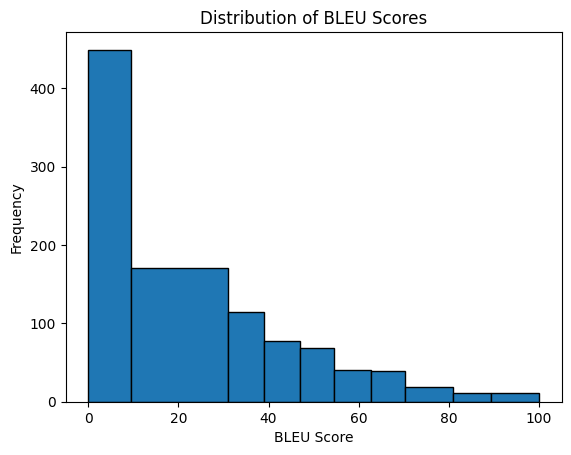

In [44]:
# Compare output of Student model with Reference from original dataset
bleu_SR, corpus_bleu_SR = batch_sentence_bleu(trg_S, test_data['en'])
print(f'Corpus bleu score is {corpus_bleu_SR}')
plot_bleu_distribution(bleu_SR)

### How good is QE

In [45]:
def token_to_number(arr):
    nums = [int(x[5:]) if x[:5] == 'bleu_' else 0 for x in arr ]
    return nums

bleu_nums_SR = token_to_number(map_bleu_scores_to_tokens_avg(bleu_SR_test))
bleu_nums_S_output = token_to_number(bleu_tokens_S_output)

II: bleu_tokens_S_output vs QE(Trg_S, Ref)

In [46]:
# todo pearson
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score

acc = accuracy_score(bleu_nums_S_output, bleu_nums_SR)
correlation_coefficient, p_value = pearsonr(bleu_nums_S_output, bleu_nums_SR)
print("The correlation coefficient is: {} (close to 1 or -1 more correlated), \np_value is {} (lower better), \naccuracy is: {}".format(correlation_coefficient, p_value, acc))

The correlation coefficient is: 0.22523597777434806 (close to 1 or -1 more correlated), 
p_value is 5.741879189138536e-13 (lower better), 
accuracy is: 0.174


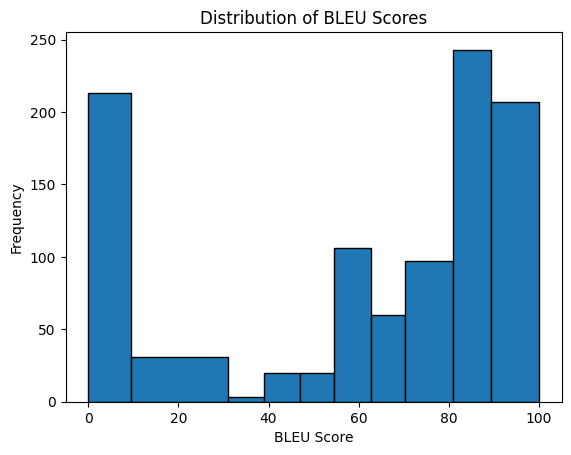

In [47]:
plot_bleu_distribution(token_to_number(bleu_tokens_S_output))



## Appendix

The `calculate_bleu` function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to [@azadyasar](https://github.com/azadyasar).

In [50]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [51]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch['src']
            trg = batch['trg']
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)